# Project 5B: Training Your Own Diffusion Model!

## Setup environment

In [ ]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00


In [ ]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch
import mediapy as media
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1,  padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg_pool = nn.AvgPool2d(7)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.avg_pool(x)
        x = self.gelu(x)
        return x


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0)
        self.bn = nn.BatchNorm2d(in_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downconv = DownConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.downconv(x)
        x = self.convblock(x)
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = UpConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)
        x = self.convblock(x)
        return x

In [ ]:
def load_MNIST(batch_size):
  train_loader = DataLoader(MNIST(root='data', train=True, transform=ToTensor(), download=True), batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(MNIST(root='data', train=False, transform=ToTensor(), download=True), batch_size=batch_size, shuffle=False)
  return train_loader, test_loader

In [ ]:
train_loader, test_loader = load_MNIST(256)

i = 0
for images, labels in train_loader:
    # print(images.squeeze().shape)
    # print(labels.shape)
    noisy = {}
    for j in [0,0.2,0.4,0.5,0.6,0.8,1]:
      img = images[0].squeeze()
      eps = torch.randn_like(img)
      noise_img = img + j*eps
      noisy[f'σ = '+str(j)] = noise_img / 2. + 0.5
    media.show_images(noisy,height=112)
    if i == 5:
      break
    i+=1

σ = 0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1


σ = 0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1


σ = 0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1


σ = 0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1


σ = 0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1


σ = 0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1


In [ ]:
def add_noise(batch, noise_level=0.5):
    eps = torch.randn_like(batch)
    noisy_batch = batch + eps * noise_level
    return noisy_batch / 2. + 0.5

for images, labels in train_loader:
    noisy_images = add_noise(images)
    noisy = {}
    for i, j in enumerate(noisy_images[:7]):
      noisy[i] = j.squeeze()
    media.show_images(noisy, height=112)
    break

0,1,2,3,4,5,6


## Implementing Unconditional UNet

In [ ]:
class UnconditionalUNet(nn.Module):
    def __init__(self, in_channels: int, num_hiddens: int):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)
        self.up1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.lastconv = Conv(num_hiddens, in_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        x1 = self.convblock1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x4 = self.flatten(x3)
        x5 = self.unflatten(x4)

        x6 = self.up1(torch.cat([x3, x5], dim=1))
        x7 = self.up2(torch.cat([x2, x6], dim=1))
        x8 = self.convblock2(torch.cat([x1, x7], dim=1))
        x_out = self.lastconv(x8)

        return x_out

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/cs180_proj5/uncond_unet'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
def save_checkpoint(epoch, model, optimizer, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f'Checkpoint saved at epoch {epoch} to {checkpoint_path}')

In [ ]:
def load_checkpoint(epoch, model, optimizer, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pth')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f'Checkpoint loaded from epoch {checkpoint["epoch"]}')
    return model, optimizer, checkpoint['epoch']

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5
start_epoch = 0
model.to(device)

train_losses = []

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, labels in train_loader:
      noisy_imgs = add_noise(imgs)
      noisy_imgs, imgs = noisy_imgs.to(device), imgs.to(device)

      outputs = model(noisy_imgs)
      curr_loss = loss(outputs, imgs)
      optimizer.zero_grad()
      curr_loss.backward()
      optimizer.step()

      train_loss += curr_loss.item() * noisy_imgs.size(0)
      train_losses.append(curr_loss.item())

    train_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")
    save_checkpoint(epoch, model, optimizer, checkpoint_dir)

Epoch [1/5], Loss: 0.0229
Checkpoint saved at epoch 0 to /content/drive/MyDrive/cs180_proj5/uncond_unet/model_epoch_0.pth
Epoch [2/5], Loss: 0.0114
Checkpoint saved at epoch 1 to /content/drive/MyDrive/cs180_proj5/uncond_unet/model_epoch_1.pth
Epoch [3/5], Loss: 0.0099
Checkpoint saved at epoch 2 to /content/drive/MyDrive/cs180_proj5/uncond_unet/model_epoch_2.pth
Epoch [4/5], Loss: 0.0091
Checkpoint saved at epoch 3 to /content/drive/MyDrive/cs180_proj5/uncond_unet/model_epoch_3.pth
Epoch [5/5], Loss: 0.0086
Checkpoint saved at epoch 4 to /content/drive/MyDrive/cs180_proj5/uncond_unet/model_epoch_4.pth


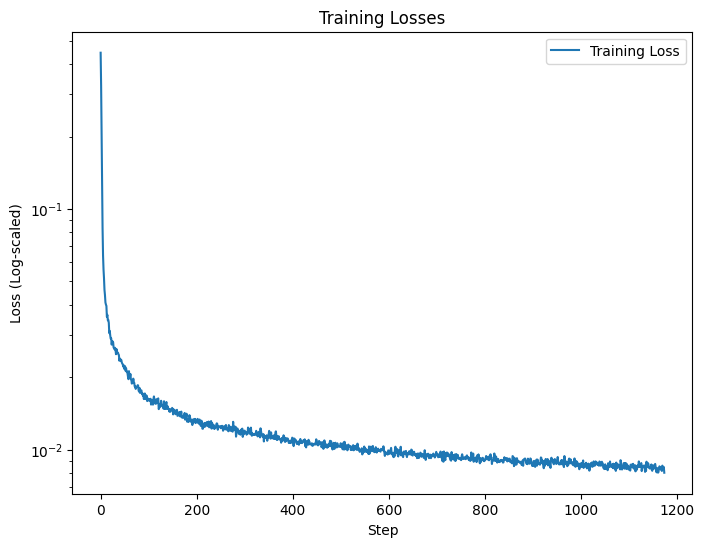

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Loss (Log-scaled)')
plt.title('Training Losses')
plt.legend()
plt.show()

In [ ]:
def test_and_display(test_loader, model, noise_levels=[0.5]):
  model.eval()
  with torch.no_grad():
    display = True
    test_loss = 0.0
    for imgs, labels in test_loader:
      noisy_imgs = add_noise(imgs)
      outputs = model(noisy_imgs)

      if display:
        if len(noise_levels) > 1:
          noise_dict = {}
          out_dict = {}
          for i in noise_levels:
            noisy_imgs2 = add_noise(imgs[:1], i)
            outputs2 = model(noisy_imgs2[:1])

            noise_dict[f"Noisy, σ={i}"] = noisy_imgs2.cpu().squeeze()
            out_dict[f"Denoised, σ={i}"] = outputs2.cpu().squeeze()
          media.show_images(noise_dict, height=112)
          media.show_images(out_dict, height=112)

        else:
          for i in range(10):
            imgs_dict = {}
            imgs_dict['input']=imgs[i].cpu().squeeze()
            imgs_dict['noisy']=noisy_imgs[i].cpu().squeeze()
            imgs_dict['output']=outputs[i].cpu().squeeze()
            media.show_images(imgs_dict, height=112)
            display=False
      break

      curr_loss = loss(outputs, imgs)

      test_loss += curr_loss.item() * noisy_imgs.size(0)

    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")
    return test_loss

In [ ]:
model = UnconditionalUNet(in_channels=1, num_hiddens=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, optimizer, epoch = load_checkpoint(0, model, optimizer, checkpoint_dir="/content/drive/MyDrive/cs180_proj5/uncond_unet")
test_and_display(test_loader, model, [0,0.2,0.4,0.5,0.6,0.8,1])

model, optimizer, epoch = load_checkpoint(4, model, optimizer, checkpoint_dir="/content/drive/MyDrive/cs180_proj5/uncond_unet")
test_and_display(test_loader, model, [0,0.2,0.4,0.5,0.6,0.8,1])

<ipython-input-12-71bff40af6cd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from epoch 0


"Noisy, σ=0","Noisy, σ=0.2","Noisy, σ=0.4","Noisy, σ=0.5","Noisy, σ=0.6","Noisy, σ=0.8","Noisy, σ=1"


"Denoised, σ=0","Denoised, σ=0.2","Denoised, σ=0.4","Denoised, σ=0.5","Denoised, σ=0.6","Denoised, σ=0.8","Denoised, σ=1"


Test Loss: 0.0000
Checkpoint loaded from epoch 4


"Noisy, σ=0","Noisy, σ=0.2","Noisy, σ=0.4","Noisy, σ=0.5","Noisy, σ=0.6","Noisy, σ=0.8","Noisy, σ=1"


"Denoised, σ=0","Denoised, σ=0.2","Denoised, σ=0.4","Denoised, σ=0.5","Denoised, σ=0.6","Denoised, σ=0.8","Denoised, σ=1"


Test Loss: 0.0000


0.0

In [ ]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for imgs, labels in test_loader:
        noisy_imgs = add_noise(imgs)
        noisy_imgs, imgs = noisy_imgs.to(device), imgs.to(device)

        outputs = model(noisy_imgs)
        curr_loss = loss(outputs, imgs)
        test_loss += curr_loss.item() * noisy_imgs.size(0)

    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0086


# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [ ]:
def seed_everything(seed):
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.linear1 = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.linear2(x)
        return x

class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)
        self.up1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.lastconv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1,  padding=1)
        self.fc1 = FCBlock(1, num_hiddens * 2)
        self.fc2 = FCBlock(1, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        N = x.shape[0]


        t = t.unsqueeze(1)
        t1 = self.fc1(t).view(N, -1, 1, 1)
        t2 = self.fc2(t).view(N, -1, 1, 1)

        x1 = self.convblock1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x4 = self.flatten(x3)
        x5 = self.unflatten(x4)
        x5 += t1

        x6 = self.up1(torch.cat([x3, x5], dim=1))
        x6 += t2

        x7 = self.up2(torch.cat([x2, x6], dim=1))
        x8 = self.convblock2(torch.cat([x1, x7], dim=1))
        x_out = self.lastconv(x8)

        return x_out

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [ ]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."

    my_dict = {}
    step = (beta2 - beta1) / num_ts
    my_dict['betas'] = torch.arange(beta1, beta2 + step, step)
    my_dict['alphas'] = 1 - my_dict['betas']
    my_dict['alpha_bars'] = torch.Tensor([np.prod(np.array(my_dict['alphas'][:i])) for i in range(num_ts)])
    return my_dict

schedule = ddpm_schedule(0.0001, 0.02, 300)

In [ ]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    batch_size = x_0.size(0)
    t = torch.randint(1, num_ts, (batch_size,)).to(device)
    eps = torch.randn_like(x_0).to(device)
    alpha_bar_t = ddpm_schedule['alpha_bars'].to(device)[t].view(-1, 1, 1, 1)
    x_t = (torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1-alpha_bar_t) * eps).to(device)
    eps_pred = unet(x_t, t/num_ts)
    return nn.MSELoss()(eps, eps_pred)

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        # self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in ddpm_schedule(betas[0], betas[1], num_ts).items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/cs180_proj5/time_cond_unet'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 20
start_epoch = 0

unet = TimeConditionalUNet(in_channels=1, num_hiddens=64, num_classes=None).to(device)
model = DDPM(unet=unet).to(device)
train_loader, test_loader = load_MNIST(128)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.1**(1./num_epochs))

train_losses = []

for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_losses = []
    for imgs, _ in train_loader:
      imgs = imgs.to(device)
      curr_loss = model(imgs)
      optimizer.zero_grad()
      curr_loss.backward()
      optimizer.step()

      train_losses.append(curr_loss.item())
      epoch_losses.append(curr_loss.item())

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(epoch_losses):.4f}")
    save_checkpoint(epoch, model, optimizer, checkpoint_dir)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.33MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Epoch [1/20], Loss: 0.0730
Checkpoint saved at epoch 0 to /content/drive/MyDrive/cs180_proj5/time_cond_unet/model_epoch_0.pth
Epoch [2/20], Loss: 0.0453
Checkpoint saved at epoch 1 to /content/drive/MyDrive/cs180_proj5/time_cond_unet/model_epoch_1.pth
Epoch [3/20], Loss: 0.0422
Checkpoint saved at epoch 2 to /content/drive/MyDrive/cs180_proj5/time_cond_unet/model_epoch_2.pth
Epoch [4/20], Loss: 0.0386
Checkpoint saved at epoch 3 to /content/drive/MyDrive/cs180_proj5/time_cond_unet/model_epoch_3.pth
Epoch [5/20], Loss: 0.0371
Checkpoint saved at epoch 4 to /content/drive/MyDrive/cs180_proj5/time_cond_unet/model_epoch_4.pth
Epoch [6/20], Loss: 0.0349
Checkpoint saved at epoch 5 to /content/drive/MyDrive/cs180_proj5/time_cond_unet/model_epoch_5.pth
Epoch [7/20], Loss: 0.0333
Checkpoint saved at epoch 6 to /content/drive/MyDrive/cs180_proj5/time_cond_unet/model_epoch_6.pth
Epoch [8/20], Loss: 0.0326
Checkpoint saved at 

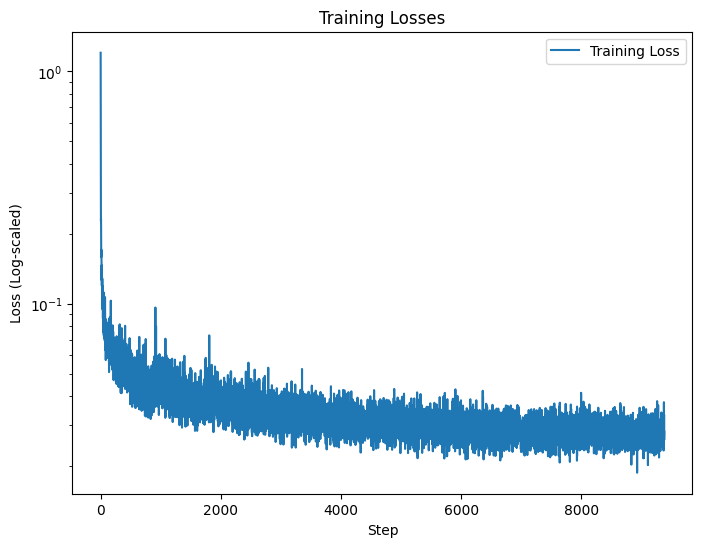

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Loss (Log-scaled)')
plt.title('Training Losses')
plt.legend()
plt.show()

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    N = 40

    seed_everything(seed)

    caches = torch.zeros((N, num_ts, 1, img_wh[0], img_wh[1]), device=device)
    x_t = torch.randn((N, 1, img_wh[0], img_wh[1])).to(device)
    for t in torch.arange(num_ts - 1, 0, -1):
      z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
      z = z.to(device)

      cache_idx = num_ts - t

      alpha_bar_t = ddpm_schedule['alpha_bars'].to(device)[t]
      alpha_bar_t_prev = ddpm_schedule['alpha_bars'].to(device)[t-1]
      alpha_t = ddpm_schedule['alphas'].to(device)[t]
      beta_t = ddpm_schedule['betas'].to(device)[t]

      t = (torch.ones(N) * t).to(device)
      noise_pred = unet(x_t, t/num_ts)

      x_0_pred = (1/(torch.sqrt(alpha_bar_t))).to(device)*(x_t-(torch.sqrt(1-alpha_bar_t)*noise_pred)).to(device)
      term1 = (torch.sqrt(alpha_bar_t_prev)*beta_t*x_0_pred)/(1-alpha_bar_t)
      term2 = (torch.sqrt(alpha_t)*(1-alpha_bar_t_prev)*x_t)/(1-alpha_bar_t)
      term3 = torch.sqrt(beta_t)*z
      x_t = term1 + term2 + term3

      caches[:, cache_idx, :, :, :] = x_t

    return x_t, caches


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_40_images(images):
  fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 6))
  plt.subplots_adjust(wspace=0, hspace=0)

  for ax, img in zip(axes.flat, images):
      ax.imshow(img, cmap='gray', aspect='auto')
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.set_frame_on(False)

  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  plt.show()

In [ ]:
import numpy as np
from PIL import Image

def plot_40_images_gif(tensor, gif_path, frame_step=10, total_duration=2.0, linger_frames=10):

    t_images = tensor

    num_images, num_timesteps, height, width = t_images.shape
    selected_timesteps = list(range(0, num_timesteps, frame_step))

    if selected_timesteps[-1] != num_timesteps - 1:
        selected_timesteps.append(num_timesteps - 1)

    frames = []
    total_frames = len(selected_timesteps) + linger_frames
    duration_per_frame = total_duration / total_frames

    for t in selected_timesteps:
        images = t_images[:, t]
        images -= images.min()
        if images.max() > 0:
            images /= images.max()
        images = (images * 255).astype(np.uint8)

        grid_image = np.zeros((height * 4, width * 10), dtype=np.uint8)

        for idx, img in enumerate(images):
            row = idx // 10
            col = idx % 10
            grid_image[row * height:(row + 1) * height, col * width:(col + 1) * width] = img

        pil_image = Image.fromarray(grid_image)
        frames.append(pil_image)

    final_frame = frames[-1]
    for _ in range(linger_frames):
        frames.append(final_frame)

    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration_per_frame * 1000,
        loop=0
    )
    print(f"GIF saved to: {gif_path}")

<ipython-input-6-71bff40af6cd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from epoch 0


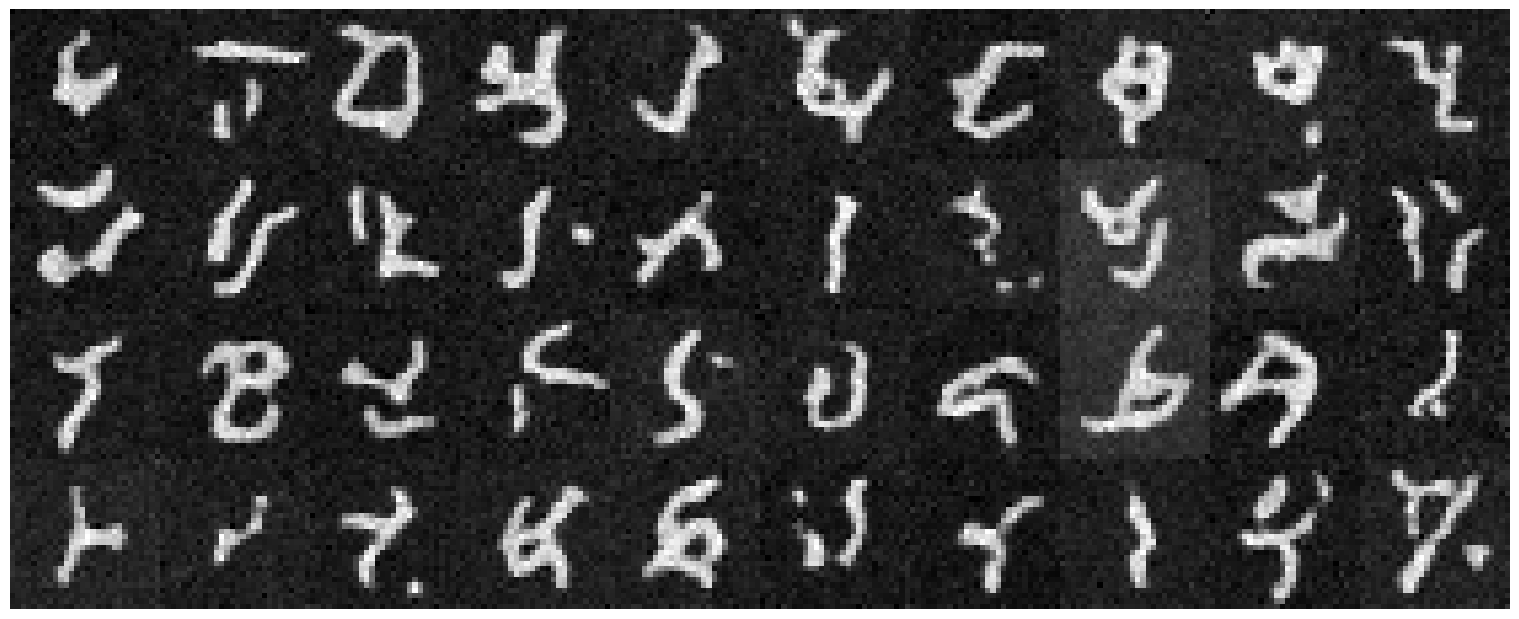

GIF saved to: /content/drive/MyDrive/cs180_proj5/time_cond_unet/epoch_1.gif


<ipython-input-6-71bff40af6cd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from epoch 4


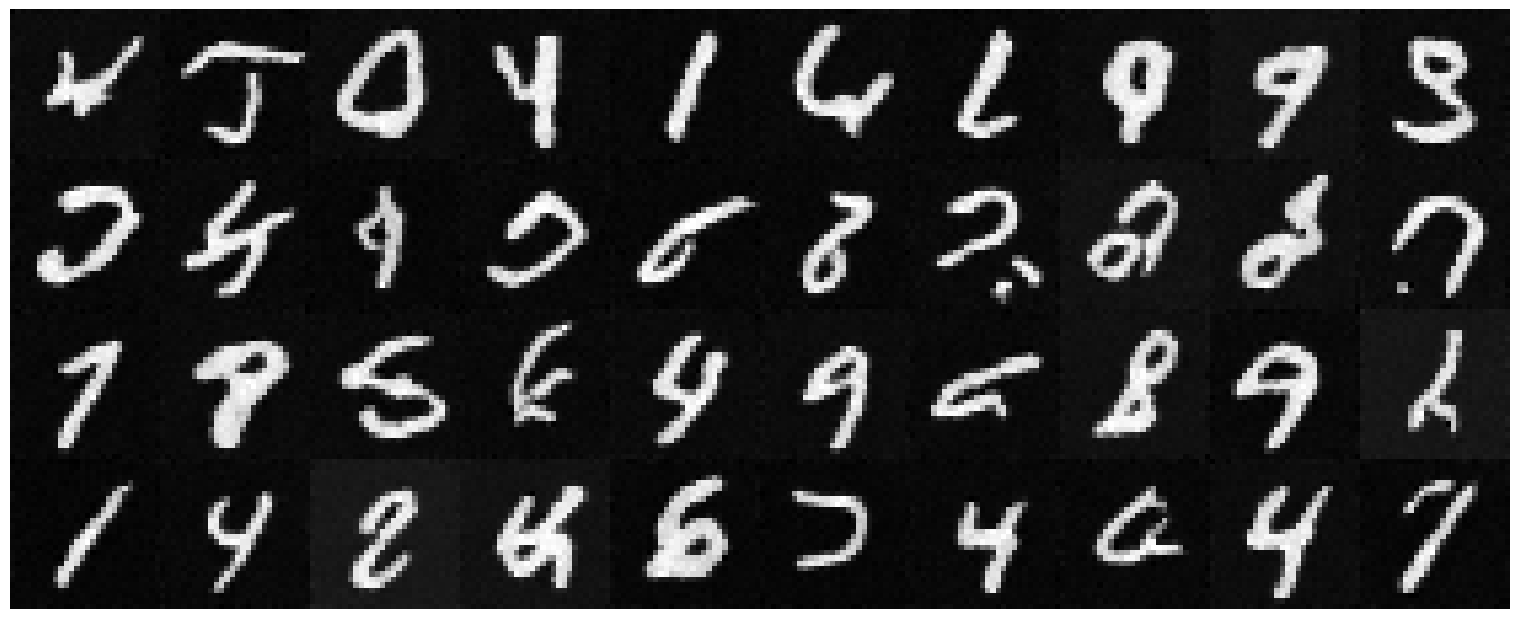

GIF saved to: /content/drive/MyDrive/cs180_proj5/time_cond_unet/epoch_5.gif


<ipython-input-6-71bff40af6cd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from epoch 9


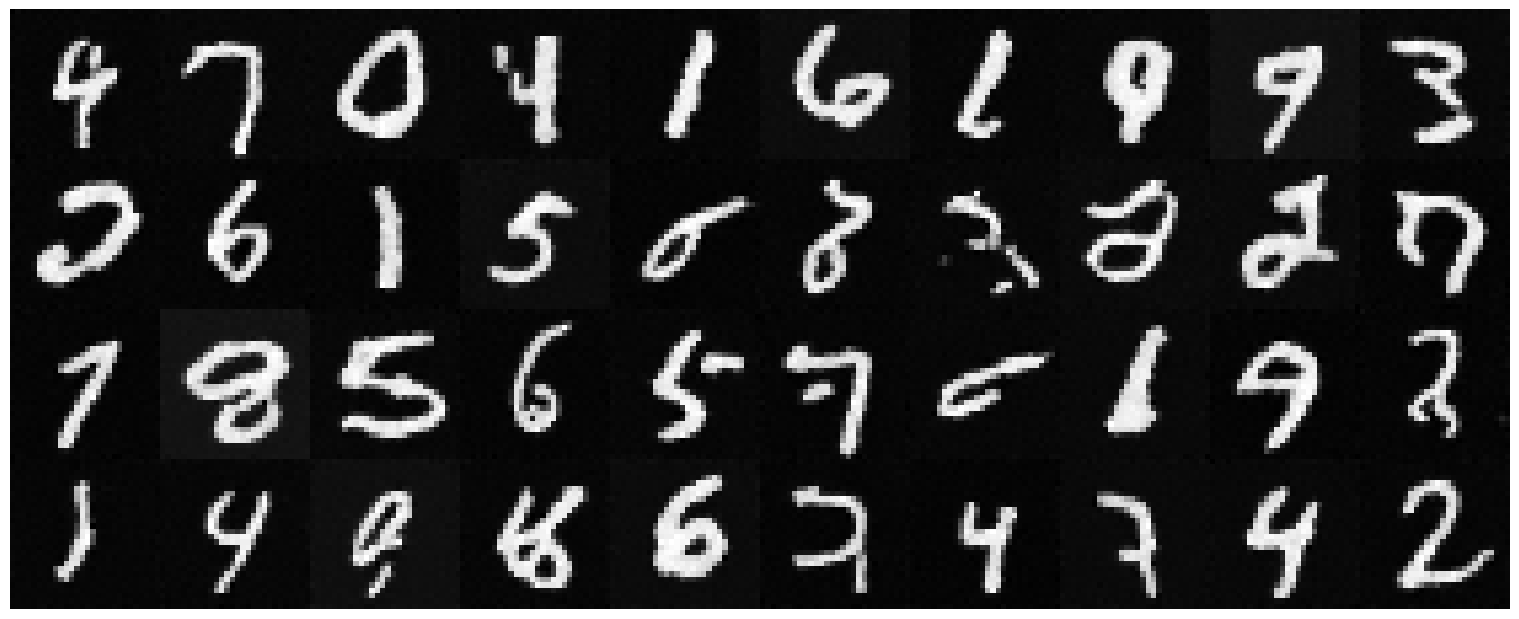

GIF saved to: /content/drive/MyDrive/cs180_proj5/time_cond_unet/epoch_10.gif


<ipython-input-6-71bff40af6cd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from epoch 14


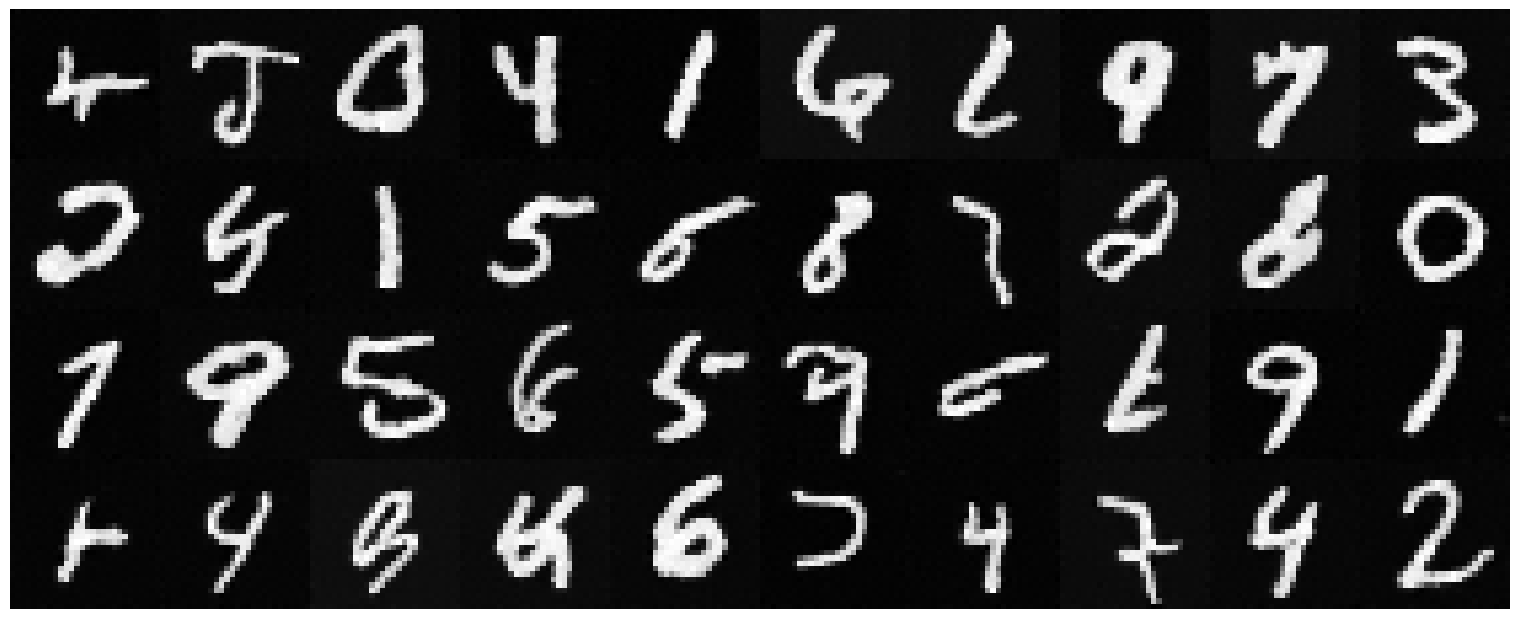

GIF saved to: /content/drive/MyDrive/cs180_proj5/time_cond_unet/epoch_15.gif


<ipython-input-6-71bff40af6cd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from epoch 19


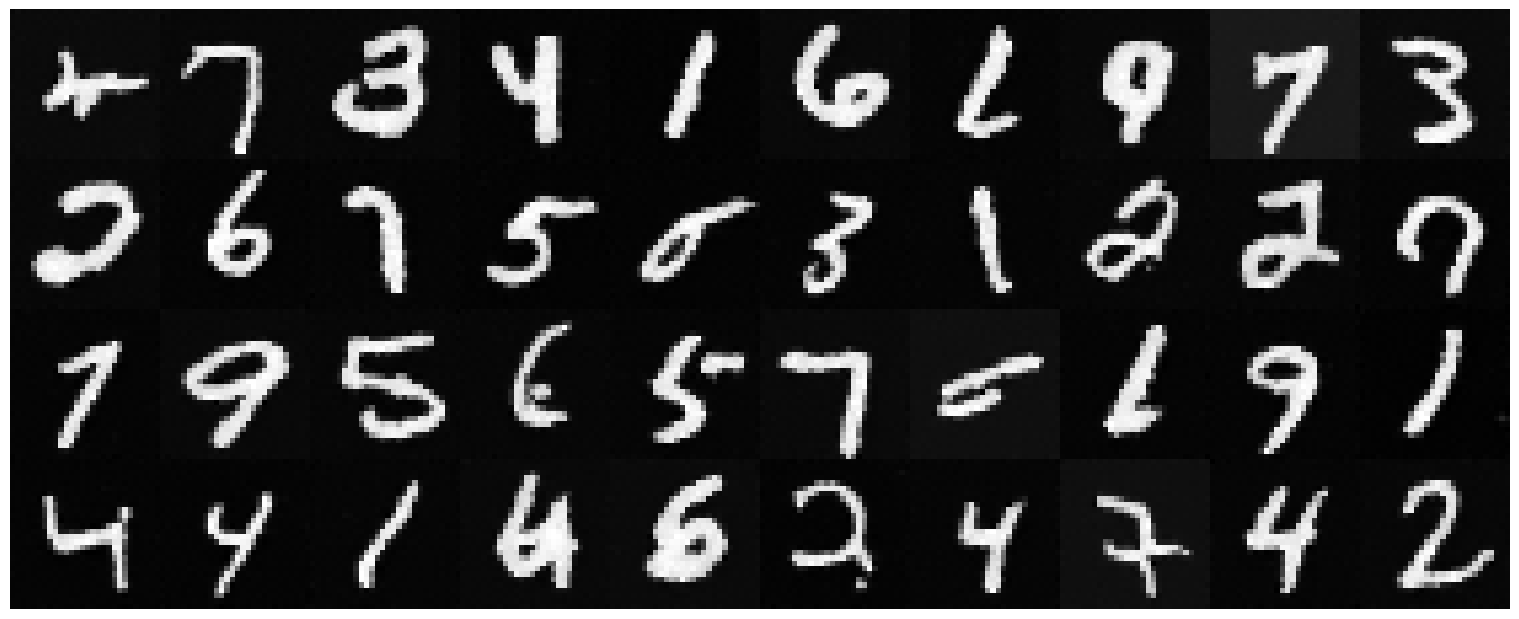

GIF saved to: /content/drive/MyDrive/cs180_proj5/time_cond_unet/epoch_20.gif


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = TimeConditionalUNet(in_channels=1, num_hiddens=64, num_classes=None).to(device)
model = DDPM(unet=unet).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

checkpoint_dir="/content/drive/MyDrive/cs180_proj5/time_cond_unet"

for i in [1,5,10,15,20]:
  model, optimizer, epoch = load_checkpoint(i-1, model, optimizer, checkpoint_dir=checkpoint_dir)
  sample, caches = ddpm_sample(model.unet, model.ddpm_schedule, (28, 28), 300, 10)
  im = sample.squeeze().cpu().numpy()
  plot_40_images(im)

  caches = caches.squeeze().cpu().numpy()
  plot_40_images_gif(caches, f"{checkpoint_dir}/epoch_{i}.gif")

### Implementing class-conditioned UNet

In [ ]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        super().__init__()
        self.num_classes = num_classes
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)
        self.up1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.lastconv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1,  padding=1)
        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)
        self.fc1_c = FCBlock(num_classes, num_hiddens * 2)
        self.fc2_c = FCBlock(num_classes, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        N = x.shape[0]

        c = torch.nn.functional.one_hot(c, num_classes=self.num_classes)
        if mask is not None:
          c = c * mask.view(N, 1)
        t = t.unsqueeze(1)

        t1 = self.fc1_t(t).view(N, -1, 1, 1)
        c1 = self.fc1_c(c).view(N, -1, 1, 1)
        t2 = self.fc2_t(t).view(N, -1, 1, 1)
        c2 = self.fc2_c(c).view(N, -1, 1, 1)

        x1 = self.convblock1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x4 = self.flatten(x3)
        x5 = self.unflatten(x4)
        x5 = c1 * x5 + t1

        x6 = self.up1(torch.cat([x3, x5], dim=1))
        x6 = c2 * x6 + t2

        x7 = self.up2(torch.cat([x2, x6], dim=1))
        x8 = self.convblock2(torch.cat([x1, x7], dim=1))
        x_out = self.lastconv(x8)

        return x_out

In [ ]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    N = x_0.size(0)
    t = torch.randint(1, num_ts, (N,)).to(device)
    eps = torch.randn_like(x_0).to(device)
    alpha_bar_t = ddpm_schedule['alpha_bars'].to(device)[t].view(-1, 1, 1, 1)
    x_t = (torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1-alpha_bar_t) * eps).to(device)

    probs = torch.full((N,), 1-p_uncond).to(device)
    mask = torch.bernoulli(probs).to(device)

    eps_pred = unet(x_t, c, t/num_ts, mask)
    return nn.MSELoss()(eps, eps_pred)

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/cs180_proj5/class_cond_unet'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 20
start_epoch = 0

unet = ClassConditionalUNet(in_channels=1, num_hiddens=64, num_classes=10).to(device)
model = DDPM(unet=unet).to(device)
train_loader, test_loader = load_MNIST(128)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.1**(1./num_epochs))

train_losses = []

for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_losses = []
    for imgs, labels in train_loader:
      imgs, labels = imgs.to(device), labels.to(device)
      curr_loss = model(imgs, labels)
      optimizer.zero_grad()
      curr_loss.backward()
      optimizer.step()

      train_losses.append(curr_loss.item())
      epoch_losses.append(curr_loss.item())

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(epoch_losses):.4f}")
    save_checkpoint(epoch, model, optimizer, checkpoint_dir)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.62MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Epoch [1/20], Loss: 0.0723
Checkpoint saved at epoch 0 to /content/drive/MyDrive/cs180_proj5/class_cond_unet/model_epoch_0.pth
Epoch [2/20], Loss: 0.0447
Checkpoint saved at epoch 1 to /content/drive/MyDrive/cs180_proj5/class_cond_unet/model_epoch_1.pth
Epoch [3/20], Loss: 0.0393
Checkpoint saved at epoch 2 to /content/drive/MyDrive/cs180_proj5/class_cond_unet/model_epoch_2.pth
Epoch [4/20], Loss: 0.0362
Checkpoint saved at epoch 3 to /content/drive/MyDrive/cs180_proj5/class_cond_unet/model_epoch_3.pth
Epoch [5/20], Loss: 0.0347
Checkpoint saved at epoch 4 to /content/drive/MyDrive/cs180_proj5/class_cond_unet/model_epoch_4.pth
Epoch [6/20], Loss: 0.0335
Checkpoint saved at epoch 5 to /content/drive/MyDrive/cs180_proj5/class_cond_unet/model_epoch_5.pth
Epoch [7/20], Loss: 0.0319
Checkpoint saved at epoch 6 to /content/drive/MyDrive/cs180_proj5/class_cond_unet/model_epoch_6.pth
Epoch [8/20], Loss: 0.0311
Checkpoint sa

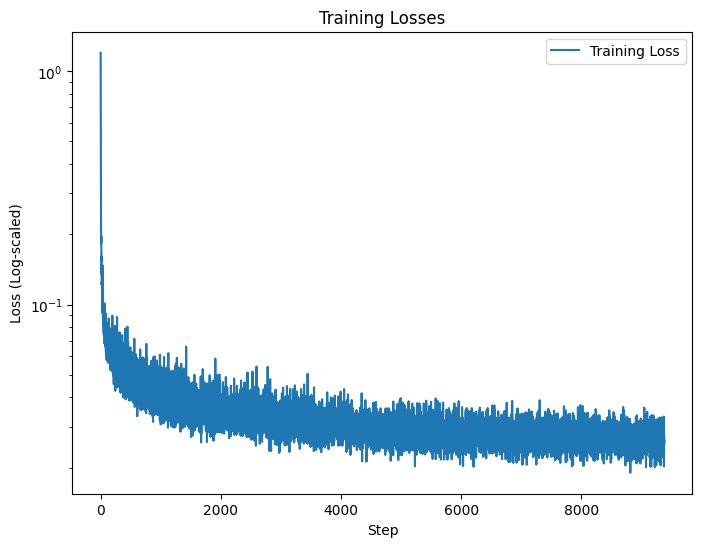

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Loss (Log-scaled)')
plt.title('Training Losses')
plt.legend()
plt.show()

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    N = 40

    seed_everything(seed)
    caches = torch.zeros((N, num_ts, 1, img_wh[0], img_wh[1]), device=device)
    x_t = torch.randn((N, 1, img_wh[0], img_wh[1])).to(device)
    for t in torch.arange(num_ts - 1, 0, -1):
      z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
      z = z.to(device)

      cache_idx = num_ts - t

      alpha_bar_t = ddpm_schedule['alpha_bars'].to(device)[t]
      alpha_bar_t_prev = ddpm_schedule['alpha_bars'].to(device)[t-1]
      alpha_t = ddpm_schedule['alphas'].to(device)[t]
      beta_t = ddpm_schedule['betas'].to(device)[t]

      t = (torch.ones(N) * t).to(device)
      eps_u = unet(x=x_t, t=t/num_ts, c=torch.zeros(N, dtype=torch.long).to(device), mask=torch.ones(N).to(device))
      eps_c = unet(x=x_t, t=t/num_ts, c=c, mask=torch.ones(N).to(device))
      eps = eps_u + guidance_scale * (eps_c - eps_u)

      x_0_pred = (1/(torch.sqrt(alpha_bar_t))).to(device)*(x_t-(torch.sqrt(1-alpha_bar_t)*eps)).to(device)
      term1 = (torch.sqrt(alpha_bar_t_prev)*beta_t*x_0_pred)/(1-alpha_bar_t)
      term2 = (torch.sqrt(alpha_t)*(1-alpha_bar_t_prev)*x_t)/(1-alpha_bar_t)
      term3 = torch.sqrt(beta_t)*z
      x_t = term1 + term2 + term3
      caches[:, cache_idx, :, :, :] = x_t

    return x_t, caches


<ipython-input-6-71bff40af6cd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from epoch 0
torch.Size([40, 1, 28, 28])


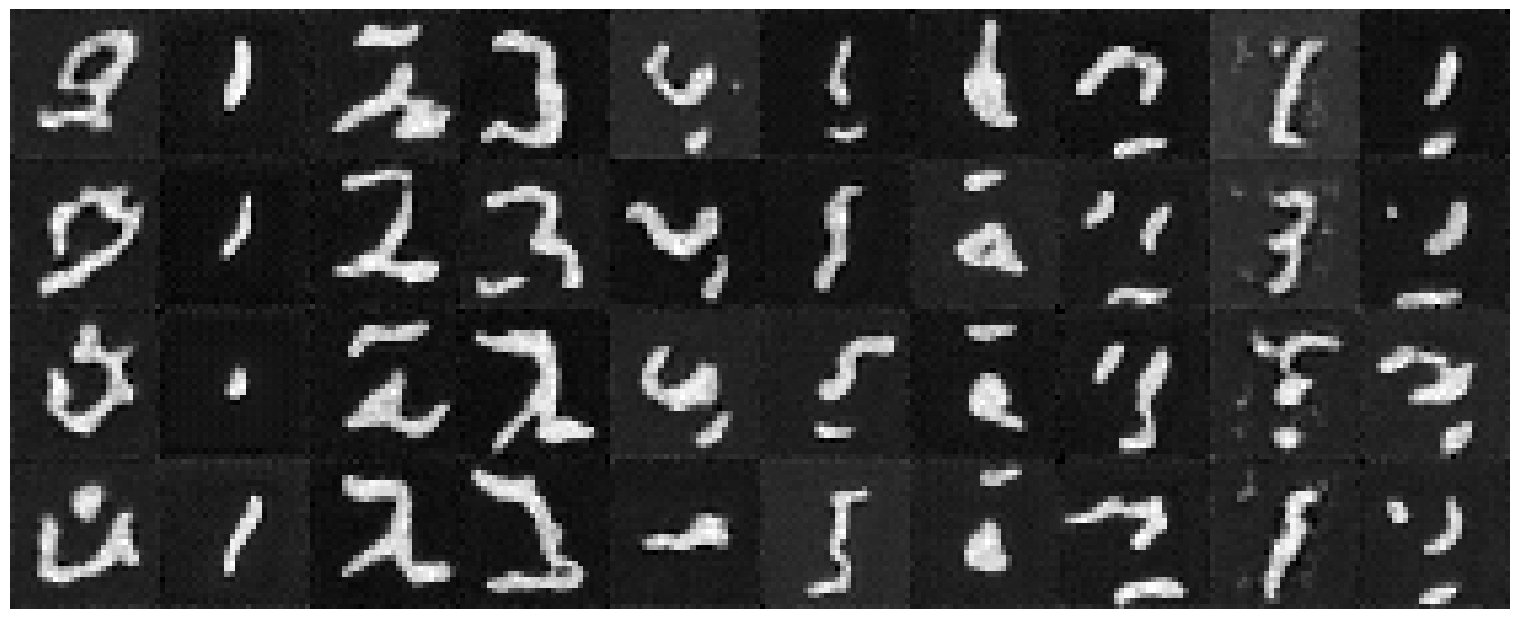

GIF saved to: /content/drive/MyDrive/cs180_proj5/class_cond_unet/epoch_1.gif
Checkpoint loaded from epoch 4


<ipython-input-6-71bff40af6cd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


torch.Size([40, 1, 28, 28])


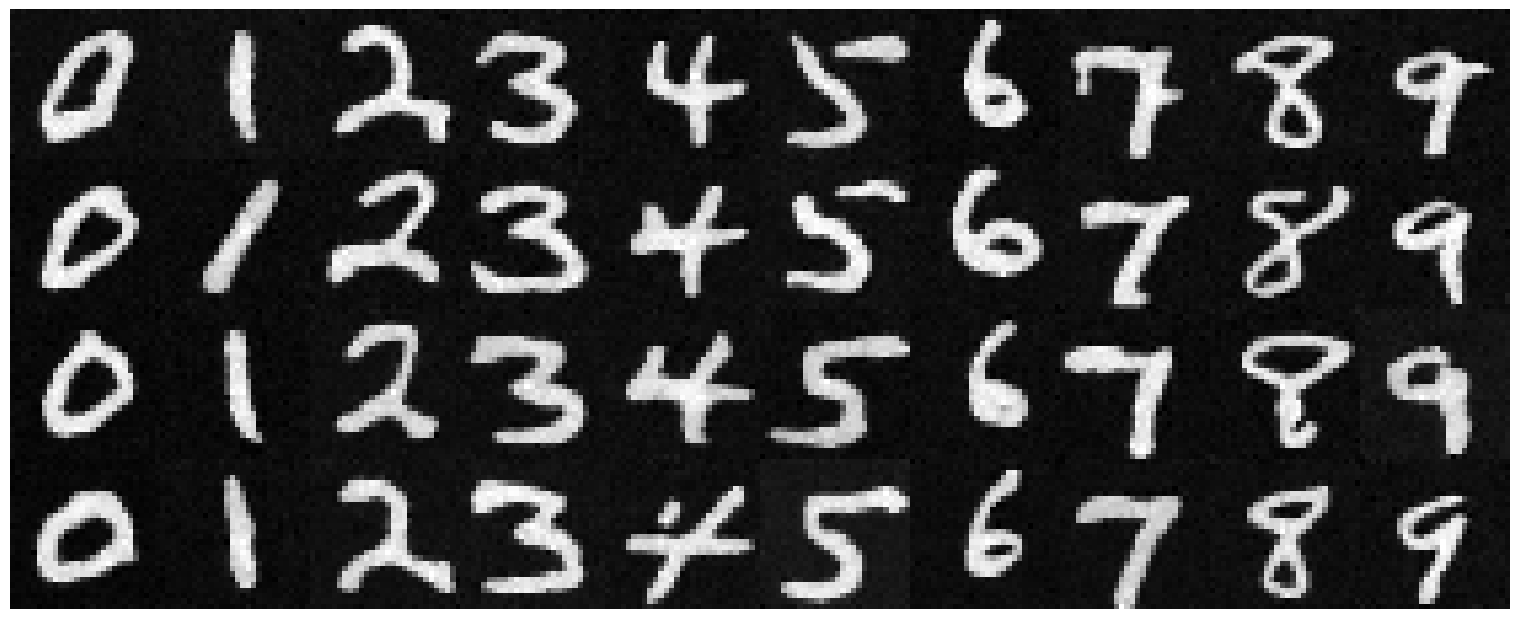

GIF saved to: /content/drive/MyDrive/cs180_proj5/class_cond_unet/epoch_5.gif
Checkpoint loaded from epoch 9


<ipython-input-6-71bff40af6cd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


torch.Size([40, 1, 28, 28])


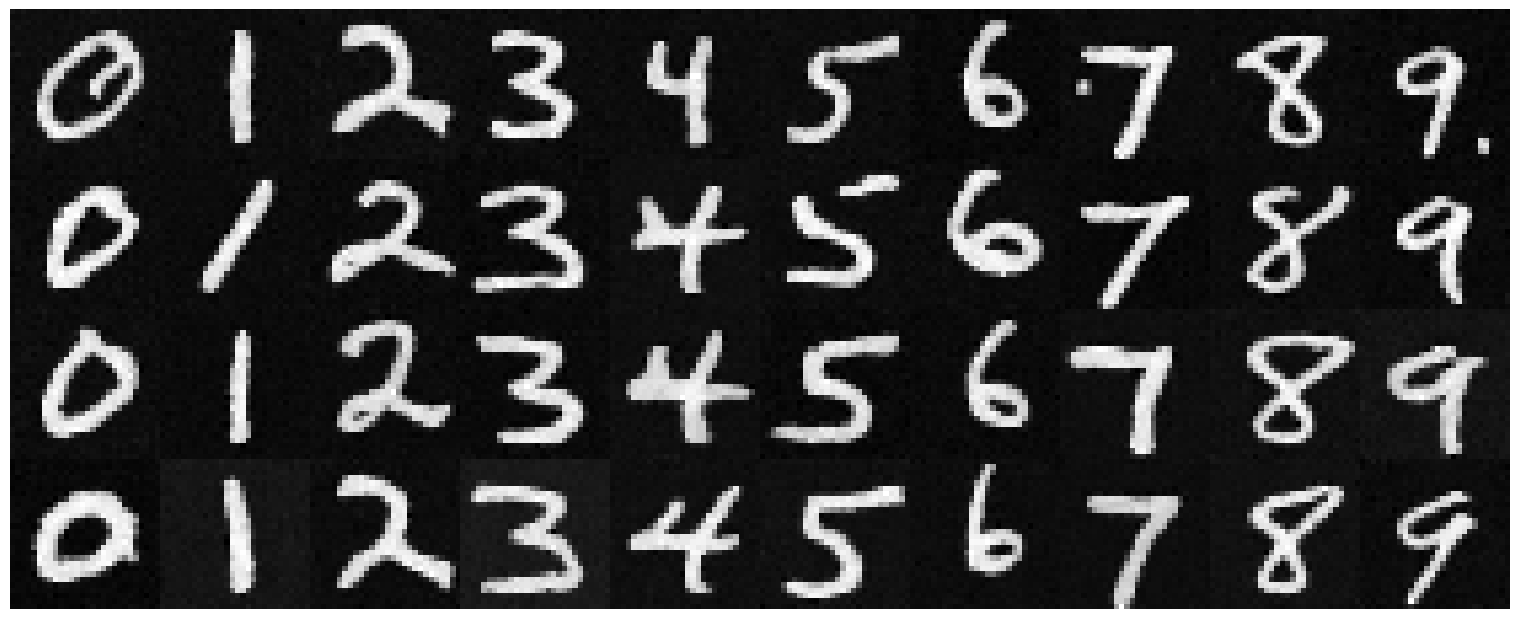

GIF saved to: /content/drive/MyDrive/cs180_proj5/class_cond_unet/epoch_10.gif
Checkpoint loaded from epoch 14


<ipython-input-6-71bff40af6cd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


torch.Size([40, 1, 28, 28])


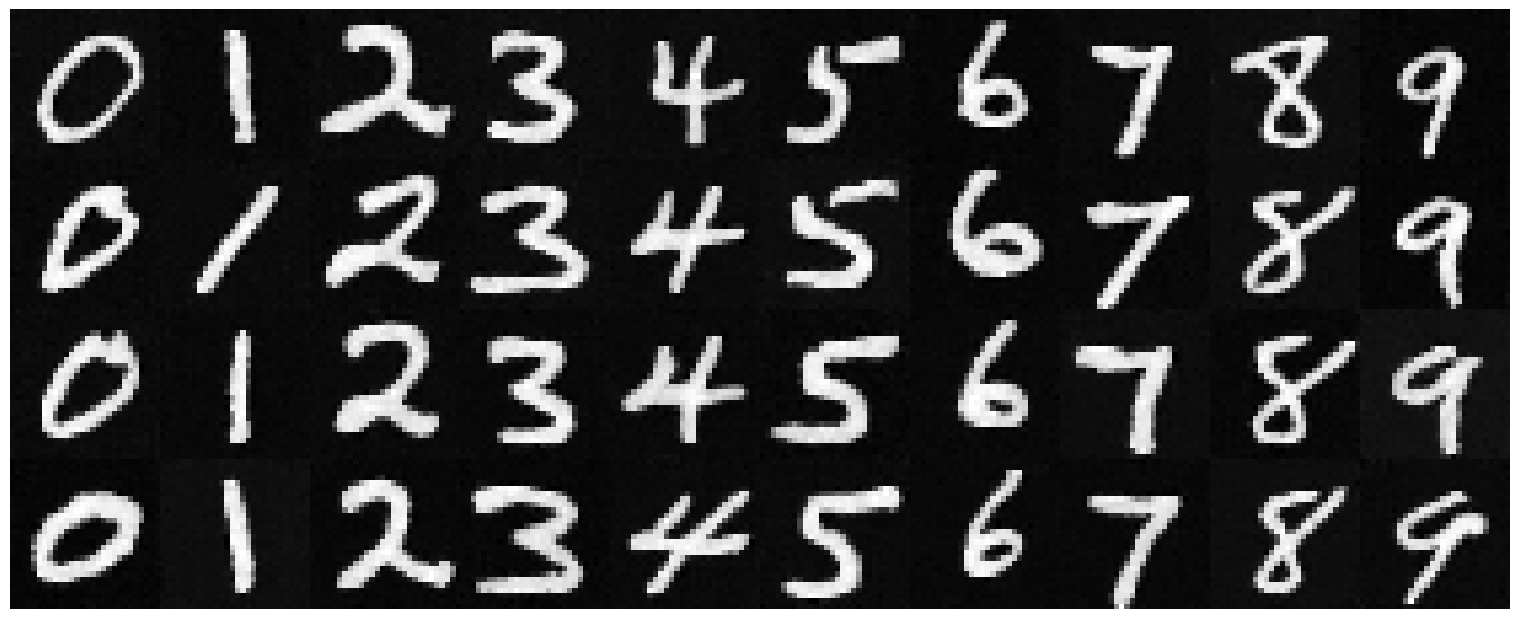

GIF saved to: /content/drive/MyDrive/cs180_proj5/class_cond_unet/epoch_15.gif
Checkpoint loaded from epoch 19


<ipython-input-6-71bff40af6cd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


torch.Size([40, 1, 28, 28])


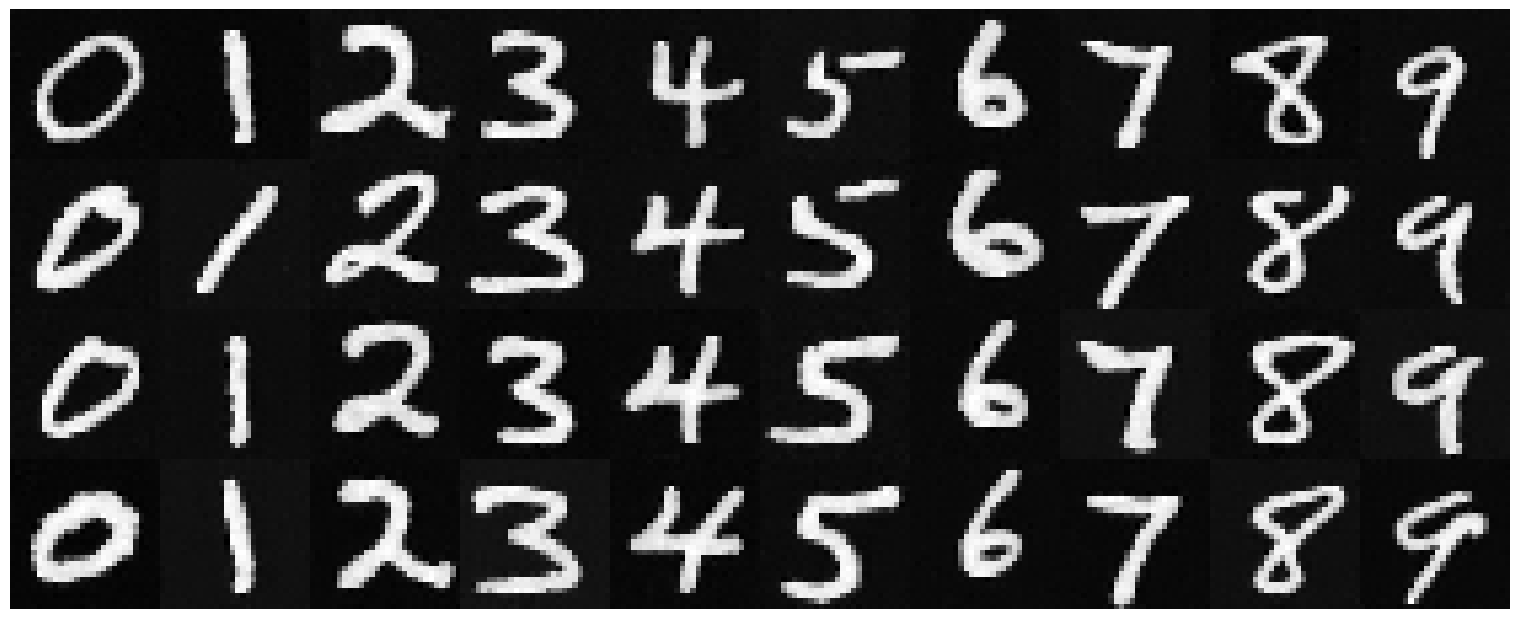

GIF saved to: /content/drive/MyDrive/cs180_proj5/class_cond_unet/epoch_20.gif


In [ ]:
import imageio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = ClassConditionalUNet(in_channels=1, num_hiddens=64, num_classes=10).to(device)
model = DDPM(unet=unet).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

checkpoint_dir="/content/drive/MyDrive/cs180_proj5/class_cond_unet"

for i in [1,5,10,15,20]:
  model, optimizer, epoch = load_checkpoint(i-1, model, optimizer, checkpoint_dir=checkpoint_dir)
  c = torch.arange(10).repeat(4).to(device)
  sample, caches = ddpm_sample(
      unet=model.unet,
      ddpm_schedule=model.ddpm_schedule,
      c=c,
      img_wh = (28, 28),
      num_ts = 300,
      seed = 0
  )
  print(sample.shape)
  im = sample.squeeze().cpu().numpy()
  plot_40_images(im)

  caches = caches.squeeze().cpu().numpy()
  plot_40_images_gif(caches, f"{checkpoint_dir}/epoch_{i}.gif")

In [ ]:
@torch.inference_mode()
def non_random_ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    N = 1

    seed_everything(seed)

    caches = torch.zeros((10, N, num_ts, 1, img_wh[0], img_wh[1]), device=device)

    x_t = torch.randn((N, 1, img_wh[0], img_wh[1])).to(device)
    for c in range(10):
      c = torch.full((N,), c).to(device)
      for t in torch.arange(num_ts - 1, 0, -1):
        z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
        z = z.to(device)

        cache_idx = num_ts - t

        alpha_bar_t = ddpm_schedule['alpha_bars'].to(device)[t]
        alpha_bar_t_prev = ddpm_schedule['alpha_bars'].to(device)[t-1]
        alpha_t = ddpm_schedule['alphas'].to(device)[t]
        beta_t = ddpm_schedule['betas'].to(device)[t]

        t = (torch.ones(N) * t).to(device)
        eps_u = unet(x=x_t, t=t/num_ts, c=torch.zeros(N, dtype=torch.long).to(device), mask=torch.ones(N).to(device))
        eps_c = unet(x=x_t, t=t/num_ts, c=c, mask=torch.ones(N).to(device))
        eps = eps_u + guidance_scale * (eps_c - eps_u)

        x_0_pred = (1/(torch.sqrt(alpha_bar_t))).to(device)*(x_t-(torch.sqrt(1-alpha_bar_t)*eps)).to(device)
        term1 = (torch.sqrt(alpha_bar_t_prev)*beta_t*x_0_pred)/(1-alpha_bar_t)
        term2 = (torch.sqrt(alpha_t)*(1-alpha_bar_t_prev)*x_t)/(1-alpha_bar_t)
        term3 = torch.sqrt(beta_t)*z
        x_t = term1 + term2 + term3
        caches[c, :, cache_idx, :, :, :] = x_t

    return x_t, caches


In [ ]:
import imageio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = ClassConditionalUNet(in_channels=1, num_hiddens=64, num_classes=10).to(device)
model = DDPM(unet=unet).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

checkpoint_dir="/content/drive/MyDrive/cs180_proj5/class_cond_unet"

for i in [1,5,10,15,20]:
  model, optimizer, epoch = load_checkpoint(i-1, model, optimizer, checkpoint_dir=checkpoint_dir)
  sample, caches = ddpm_sample(
      unet=model.unet,
      ddpm_schedule=model.ddpm_schedule,
      img_wh = (28, 28),
      num_ts = 300,
      seed = 0
  )
  print(sample.shape)
  im = sample.squeeze().cpu().numpy()
  plot_40_images(im)

  caches = caches.squeeze().cpu().numpy()
  plot_40_images_gif(caches, f"{checkpoint_dir}/epoch_{i}.gif")